In [1]:
import zipfile

In [2]:
zip_file=zipfile.ZipFile("train.zip")
zip_file.extractall('.')

In [4]:
zip_file=zipfile.ZipFile("test.zip")
zip_file.extractall('./test/')

In [5]:
import glob
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
from tqdm import tqdm
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, MaxPooling2D, BatchNormalization,concatenate,Input
from tensorflow.keras import Model

import warnings
warnings.filterwarnings("ignore")

In [8]:
# train data 생성

train_files=glob.glob("train\*.npy")
len(train_files)

62735

In [10]:
def trainGenerator():
    for file in train_files:
        dataset = np.load(file)
        target= dataset[:,:,-1].reshape(120,120,1)
        remove_minus = np.where(target < 0, 0, target)
        feature = dataset[:,:,:4]

        yield (feature, remove_minus)
        
train_dataset = tf.data.Dataset.from_generator(trainGenerator, (tf.float32, tf.float32), (tf.TensorShape([120,120,4]),tf.TensorShape([120,120,1])))
train_dataset = train_dataset.batch(256).prefetch(1)

In [11]:
train_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 120, 120, 4), dtype=tf.float32, name=None), TensorSpec(shape=(None, 120, 120, 1), dtype=tf.float32, name=None))>

In [12]:
color_map = plt.cm.get_cmap('RdBu')
color_map = color_map.reversed()
image_sample = np.load(train_files[42])

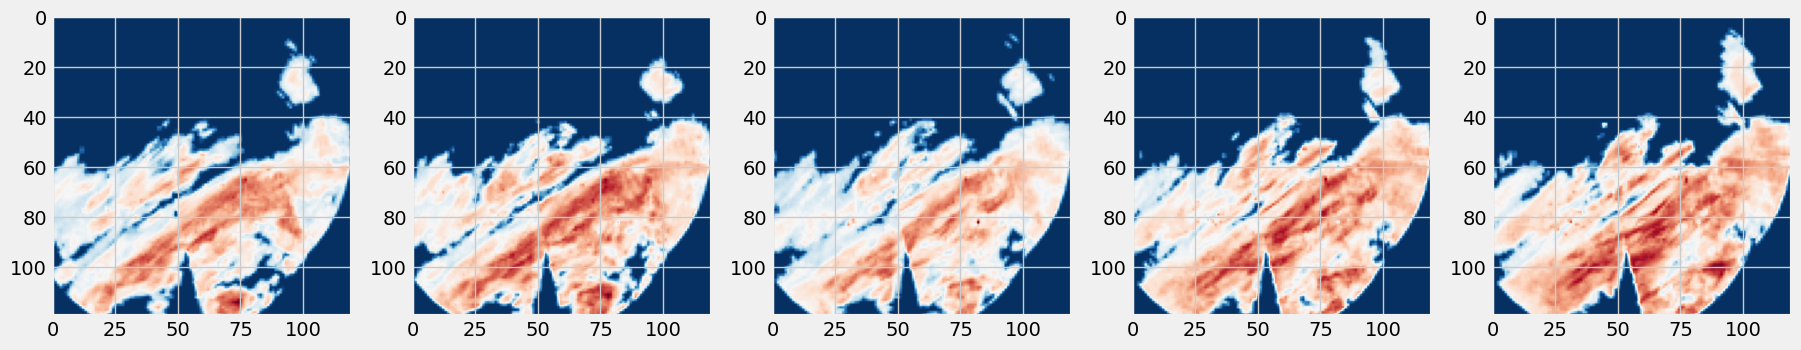

In [13]:
plt.style.use('fivethirtyeight')
plt.figure(figsize=(20, 20))

for i in range(4):
    plt.subplot(1,5,i+1)
    plt.imshow(image_sample[:, :, i], cmap=color_map)

plt.subplot(1,5,5)
plt.imshow(image_sample[:,:,-1], cmap = color_map)
plt.show()

model

In [14]:
def base_model(input_layer, start_neurons):
    
    conv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(input_layer)
    pool1 = BatchNormalization()(conv1)
    pool1 = MaxPooling2D((2, 2))(pool1)

    conv2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(pool1)
    pool2 = BatchNormalization()(conv2)
    pool2 = MaxPooling2D((2, 2))(pool2)

    convm = Conv2D(start_neurons * 4, (3, 3), activation="relu", padding="same")(pool2)

    deconv2 = Conv2DTranspose(start_neurons * 2, (3, 3), strides=(2, 2), padding="same")(convm)
    uconv2 = concatenate([deconv2, conv2])
    uconv2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(uconv2)
    uconv2 = BatchNormalization()(uconv2)

    deconv1 = Conv2DTranspose(start_neurons * 1, (3, 3), strides=(2, 2), padding="same")(uconv2)
    uconv1 = concatenate([deconv1, conv1])
    uconv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(uconv1)
    uconv1 = BatchNormalization()(uconv1)
    output_layer = Conv2D(1, (1,1), padding="same", activation='relu')(uconv1)
    
    return output_layer

input_layer = Input((120, 120, 4))
output_layer = base_model(input_layer,64)

In [15]:
model = Model(input_layer, output_layer)
model.compile(loss='mae', optimizer='adam')
model.fit(train_dataset, epochs = 5, verbose=1)

Epoch 1/5
     64/Unknown - 4470s 70s/step - loss: 10.6664